## Notebook 3: Análisis y Visualización
En este notebook realizaremos las siguientes operaciones:
1. Estadísticas: calcular estadísticas descriptivas como media, mediana, desviación estándar y percentiles.
2. Valores atípicos: detectar puntos de datos que son significativamente diferentes de otros.
3. Visualización:
    - Distribución de los datos: utilizar elementos como histogramas o boxplots para ver y entender mejor cómo se distribuyen los datos.
    - Correlaciones: podremos también utilizar gráficos de dispersión para identificar correlaciones.
4. Sacar conclusiones.

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.append("../")
from src import soporte_limpieza as sl
from src import soporte_variables as sv

pd.set_option('display.max_columns', None) 
# pd.options.display.float_format = '{:.2f}'.format #suprimir notación científica
pd.options.display.float_format = '{:,}'.format #usar separadores miles

In [38]:
# Importo un único dataframe que exporta del notebook "Limpieza", que contiene los datos limpios para el análisis.

df = pd.read_csv("../datos/brasil_limpio.csv")

In [39]:
# Convertimos la columna año a formato pandas.
df['ano_ejercicio'] = pd.to_datetime(df['ano_ejercicio'], format='%Y')

In [40]:
#Comprobamos integridad del DF con shape, columns y dtypes.
df.shape

(903723, 11)

In [41]:
df.columns

Index(['organo_superior', 'organo', 'unidad_gestora', 'categoria_economica',
       'origen_ingreso', 'tipo_ingreso', 'valor_previsto_actualizado',
       'valor_registrado', 'valor_ejecutado', 'porcentaje_ejecutado',
       'ano_ejercicio'],
      dtype='object')

In [42]:
df.dtypes

organo_superior                       object
organo                                object
unidad_gestora                        object
categoria_economica                   object
origen_ingreso                        object
tipo_ingreso                          object
valor_previsto_actualizado           float64
valor_registrado                     float64
valor_ejecutado                      float64
porcentaje_ejecutado                 float64
ano_ejercicio                 datetime64[ns]
dtype: object

In [43]:
# E imprimimos una muestra para comprobar que los registros son los esperados.
df.sample(5)

,organo_superior,organo,unidad_gestora,categoria_economica,origen_ingreso,tipo_ingreso,valor_previsto_actualizado,valor_registrado,valor_ejecutado,porcentaje_ejecutado,ano_ejercicio
159602,Ministério das Comunicações,Agêncial Nacional de Telecomunicações,AGENCIA NACIONAL DE TELECOMUNICACOES-SEDE,Ingresos Corrientes,Outras Receitas Correntes,"Indemnizaciones, devoluciones y reembolsos",0.0,0.0,124.63,0.0,2016-01-01
505460,"Ministério da Agricultura, Pecuária e Abastec",Companhia Nacional de Abastecimento,COMPANHIA NACIONAL DE ABASTECIMENTO,Ingresos Corrientes,Outras Receitas Correntes,"Multas administrativas, contractuales y judici...",0.0,0.0,108.34,0.0,2019-01-01
67796,Ministério da Economia,Instituto Nacional do Seguro Social,"COORD.GERAL DE ORCAMENTO, FINANCAS E CONTAB.",Ingresos Corrientes,Outras Receitas Correntes,Otros ingresos corrientes,0.0,0.0,50.81,0.0,2016-01-01
594446,Ministério da Educação,Fundação Universidade Federal do Acre,FUNDACAO UNIVERSIDADE FEDERAL DO ACRE,Ingresos Corrientes,Ingresos por Servicios,Servicios Administrativos y Comerciales Generales,0.0,0.0,"8,759.0",0.0,2019-01-01
550193,Ministério da Economia,Instituto Nacional da Propriedade Industrial,INSTITUTO NACIONAL DA PROPRIEDADE INDUSTRIAL,Ingresos Corrientes - intra-presupuestarios,Ingresos por Servicios,Servicios Administrativos y Comerciales Generales,0.0,0.0,"5,950.0",0.0,2019-01-01


In [44]:
# DE MOMENTO, HE ELIMINADO "FECHA_REGISTRO" EN LIMPIEZA, PARA TRABAJAR DIRECTAMENTE CON "ANO_EJERCICIO", POR LO QUE, LO SIGUIENTE NO APLICARÍA:
# Al exportar, tenemos nuevamente un problema con el tipo de dato de la fecha, que tendría que ser datetime, así que la pasaremos nuevamente por nuestra función.
# sl.conversion_fecha(df, "fecha_registro")

In [45]:
# tendencia anual (análisis temporal)
# análisis por categoría económica y por órgano
# mencionar moneda
# outliers

Para empezar el análisis, conviene recordar los conceptos de partidas que tenemos, de acuerdo con el gobierno de Brasil:

- `valor previsto actualizado`: Monto actualizado del ingreso previsto.

- `valor registrado`: Monto que fue registrado como recaudado (ejecutado).

- `valor ejecutado`: Monto realmente recaudado.

- `porcentaje ejecutado`: Porcentaje de ejecución respecto al valor previsto.

Nos interesa recordar también, los objetivos de este EDA:
1. **Distribución de Ingresos por Categoría Económica:**

   - Analizar las categorías de ingresos más significativas y su participación en los ingresos totales.

   - Calcular la diferencia promedio entre ingresos previstos y realizados por cada categoría.

2. **Análisis Temporal:**

   - Evaluar las tendencias a lo largo del tiempo, por ejemplo, cómo cambian los ingresos realizados de un mes a otro o de un año a otro.

3. **Identificación de Discrepancias:**

   - Investigar las categorías con mayor diferencia entre lo previsto y lo realizado, identificando patrones en la subejecución o sobre ejecución.

### Distribución de ingresos por categoría

- Empezaremos por analizar cómo se distribuyen los ingresos por categoría, así que, contaremos la cantidad de registros por categoría económica.

In [46]:
df.groupby("categoria_economica")[["valor_ejecutado"]].count()

,valor_ejecutado
categoria_economica,
Desconocido,16836
Ingresos Corrientes,846688
Ingresos Corrientes - intra-presupuestarios,14042
Ingresos de Capital,26074
Ingresos de Capital - intra-presupuestarios,83


- Los convertimos a porcentaje para que sean más representativos:

In [47]:
round(df.groupby("categoria_economica")[["valor_ejecutado"]].count() / df.shape[0] * 100, 2)

,valor_ejecutado
categoria_economica,
Desconocido,1.86
Ingresos Corrientes,93.69
Ingresos Corrientes - intra-presupuestarios,1.55
Ingresos de Capital,2.89
Ingresos de Capital - intra-presupuestarios,0.01


- Podemos ver que, los ingresos corrientes representan un 94% de los datos totales, pero tendremos que saber ahora, en moneda, qué porcentaje representa cada una de estas partidas, para conocer su peso sobre las cuentas totales.

In [48]:
df_ingresos_categoria = df.groupby("categoria_economica")[["valor_ejecutado","valor_previsto_actualizado",]].sum()

df_ingresos_categoria["ratio_ejec_total"] = round(df_ingresos_categoria["valor_ejecutado"] 
/ df_ingresos_categoria["valor_ejecutado"].sum() * 100,0)

df_ingresos_categoria = df_ingresos_categoria.sort_values(by="valor_ejecutado", ascending=False).reset_index()

df_ingresos_categoria["ano_ejercicio"] = df["ano_ejercicio"]

df_ingresos_categoria



,categoria_economica,valor_ejecutado,valor_previsto_actualizado,ratio_ejec_total,ano_ejercicio
0,Ingresos de Capital,"11,260,681,585,317.42","13,168,832,871,799.4",49.0,2013-01-01
1,Ingresos Corrientes,"10,947,368,785,702.92","11,433,857,865,620.69",48.0,2013-01-01
2,Desconocido,"296,675,629,347.32","1,011,244,190,367.19",1.0,2013-01-01
3,Ingresos Corrientes - intra-presupuestarios,"270,773,436,849.65","268,676,634,102.0",1.0,2013-01-01
4,Ingresos de Capital - intra-presupuestarios,"20,096,501,112.780003","10,808,411,537.0",0.0,2013-01-01


- Con este nuevo dataframe, identificamos que, los ingresos corrientes representan un 94% del total de los datos, pero en moneda, significan un 48% de los ingresos.

- Por otro lado, los ingresos de capital, que sólamente significan un 3% de los datos totales, representan un 49% de los ingresos, siendo la principal fuente de ingresos del gobierno.

- La categoría de "Desconocido", donde hemos agrupado aquellos registros con valores nulos o "sem informação", representan un 1,86% de los ingresos, con lo cual, no deberían distorsionar nuestro análisis.

- Calcularemos ahora la diferencia entre los montos previstos y recaudados, en un nuevo dataframe.

In [49]:
# Excluyo los nulos
df_previsto_ejecutado_cat = df[df["valor_ejecutado"].notna() & df["valor_previsto_actualizado"].notna()][["categoria_economica", "valor_ejecutado", "valor_previsto_actualizado"]]
df_previsto_ejecutado_cat

,categoria_economica,valor_ejecutado,valor_previsto_actualizado
0,Ingresos Corrientes,"1,297.13",0.0
1,Ingresos Corrientes,"26,666,621.42",0.0
2,Ingresos Corrientes,"301,251.13",0.0
3,Ingresos Corrientes,"1,855.58",0.0
4,Ingresos Corrientes,"52,140.68",0.0
...,...,...,...
903718,Ingresos de Capital,0.0,"10,247,198.0"
903719,Ingresos de Capital,0.0,"16,940,891.0"
903720,Ingresos Corrientes,0.0,"200,000.0"
903721,Ingresos Corrientes,"1,000,000.0",0.0


- Para que los resultados sean interpretables, vamos a agrupar por categoría económica y ver los datos de manera porcentual.

In [60]:
# Columna diferencia recaudado/previsto
df_previsto_ejecutado_cat["diferencia"] = df_previsto_ejecutado_cat["valor_ejecutado"] - df_previsto_ejecutado_cat["valor_previsto_actualizado"]

# Columna ratio recaudado/previsto
df_previsto_ejecutado_cat["ratio_recaudado/previsto"] = df_previsto_ejecutado_cat["diferencia"]/df_previsto_ejecutado_cat["valor_previsto_actualizado"] * 100

# Agrupado media por categoría económica
df_diferencia_cat = df_previsto_ejecutado_cat.groupby("categoria_economica")[["diferencia"]].mean().round(0).reset_index()

df_diferencia_cat

,categoria_economica,diferencia
0,Desconocido,"-42,442,894.0"
1,Ingresos Corrientes,"-574,579.0"
2,Ingresos Corrientes - intra-presupuestarios,"149,324.0"
3,Ingresos de Capital,"-73,182,146.0"
4,Ingresos de Capital - intra-presupuestarios,"111,904,694.0"


In [51]:
df_previsto_ejecutado_cat

,categoria_economica,valor_ejecutado,valor_previsto_actualizado,diferencia,ratio_recaudado/previsto
0,Ingresos Corrientes,"1,297.13",0.0,"1,297.13",inf
1,Ingresos Corrientes,"26,666,621.42",0.0,"26,666,621.42",inf
2,Ingresos Corrientes,"301,251.13",0.0,"301,251.13",inf
3,Ingresos Corrientes,"1,855.58",0.0,"1,855.58",inf
4,Ingresos Corrientes,"52,140.68",0.0,"52,140.68",inf
...,...,...,...,...,...
903718,Ingresos de Capital,0.0,"10,247,198.0","-10,247,198.0",-100.0
903719,Ingresos de Capital,0.0,"16,940,891.0","-16,940,891.0",-100.0
903720,Ingresos Corrientes,0.0,"200,000.0","-200,000.0",-100.0
903721,Ingresos Corrientes,"1,000,000.0",0.0,"1,000,000.0",inf


- En los dataframe anteriores, queda patente que, las diferencias entre lo recaudado y lo previsto para todas las categorías son muy altas, hasta de un 100%.

### Análisis Temporal

In [52]:
# Calculamos la suma de los ingresos anuales previstos, registrados y ejecutados en un nuevo DF.

df_ingresos_anuales = round(df.groupby("ano_ejercicio")[["valor_previsto_actualizado","valor_registrado","valor_ejecutado"]].sum().reset_index(),0)

df_ingresos_anuales

,ano_ejercicio,valor_previsto_actualizado,valor_registrado,valor_ejecutado
0,2013-01-01,"1,878,907,730,497.0","36,097,705.0","1,577,778,876,823.0"
1,2014-01-01,"2,168,909,220,148.0","38,389,157.0","2,059,270,306,608.0"
2,2015-01-01,"2,556,218,693,479.0","60,645,454.0","2,396,627,354,081.0"
3,2016-01-01,"2,477,383,404,147.0","5,556,089.0","2,430,189,528,319.0"
4,2017-01-01,"3,302,128,310,472.0","1,585,463.0","2,183,460,599,708.0"
5,2018-01-01,"3,418,634,526,269.0","38,380,314.0","2,653,709,434,217.0"
6,2019-01-01,"2,886,115,355,751.0","219,911,638.0","2,709,765,467,311.0"
7,2020-01-01,"3,348,685,411,208.0","2,755,316,190.0","3,290,353,859,538.0"
8,2021-01-01,"3,856,437,321,456.0","14,621,809.0","3,494,440,511,726.0"


A primera vista, vemos que, hay diferencias significativas entre los montos previstos y los recaudados, pero principalmente en los que se registraron.

En cifras absolutas, es difícil interpretar estos datos, así que calcularemos ratios.

In [53]:
df_ingresos_anuales["ratio_recaudado_previsto"] = round(df_ingresos_anuales["valor_ejecutado"]/df_ingresos_anuales["valor_previsto_actualizado"] *100,0)

df_ingresos_anuales["ratio_registrado_recaudado"] = round(df_ingresos_anuales["valor_registrado"]/df_ingresos_anuales["valor_ejecutado"] *100,0)

df_ingresos_anuales

,ano_ejercicio,valor_previsto_actualizado,valor_registrado,valor_ejecutado,ratio_recaudado_previsto,ratio_registrado_recaudado
0,2013-01-01,"1,878,907,730,497.0","36,097,705.0","1,577,778,876,823.0",84.0,0.0
1,2014-01-01,"2,168,909,220,148.0","38,389,157.0","2,059,270,306,608.0",95.0,0.0
2,2015-01-01,"2,556,218,693,479.0","60,645,454.0","2,396,627,354,081.0",94.0,0.0
3,2016-01-01,"2,477,383,404,147.0","5,556,089.0","2,430,189,528,319.0",98.0,0.0
4,2017-01-01,"3,302,128,310,472.0","1,585,463.0","2,183,460,599,708.0",66.0,0.0
5,2018-01-01,"3,418,634,526,269.0","38,380,314.0","2,653,709,434,217.0",78.0,0.0
6,2019-01-01,"2,886,115,355,751.0","219,911,638.0","2,709,765,467,311.0",94.0,0.0
7,2020-01-01,"3,348,685,411,208.0","2,755,316,190.0","3,290,353,859,538.0",98.0,0.0
8,2021-01-01,"3,856,437,321,456.0","14,621,809.0","3,494,440,511,726.0",91.0,0.0


In [54]:
df_ingresos_anuales[["ratio_recaudado_previsto"]].mean()

ratio_recaudado_previsto   88.66666666666667
dtype: float64

In [55]:
df_ingresos_anuales[["ratio_registrado_recaudado"]].mean()

ratio_registrado_recaudado   0.0
dtype: float64

Ahora tenemos una vista más clara, y vemos que ocurren dos fenómenos:
1. De media, se recauda un 88.67% de las previsiones del gobierno.
2. Sin embargo, no se registra ni un 0% de lo que realmente se ingresa. Sin indagar más, se puede concluir que hay un descontrol absoluto sobre el registro de los ingresos, que implicaría la pérdida completa de trazabilidad de esos ingresos, teniendo datos poco fiables para preparar los presupuestos del Estado y, abriendo las puertas a, por ejemplo, prácticas de corrupción.

In [56]:
df.groupby("ano_ejercicio")[["valor_ejecutado"]].describe().reset_index()

ano_ejercicio valor_ejecutado                                             \
                          count                 mean                   std   
0    2013-01-01         3,843.0  410,559,166.4906142    7,643,673,625.6478   
1    2014-01-01         3,876.0  531,287,488.8049252  10,818,704,213.42943   
2    2015-01-01         3,935.0   609,053,965.458986 13,615,383,291.200209   
3    2016-01-01       172,831.0  14,061,074.27671396   880,914,190.3588994   
4    2017-01-01       164,821.0 13,247,466.037141018  437,682,197.43215287   
5    2018-01-01       152,820.0 17,364,935.441808533   639,570,998.5666689   
6    2019-01-01       154,762.0 17,509,243.013857927  493,464,437.85910374   
7    2020-01-01       127,001.0 25,908,094.105853498 1,149,685,853.3968027   
8    2021-01-01       119,834.0 29,160,676.533587545   716,570,707.4681927   

                                                                        \
                  min               25%       50%                  75%   
0     -111,172,781.62 585.9200000000001  50,000.0          959,437.185   
1     -624,211,482.24 516.8774999999999 46,652.08 1,034,421.1000000001   
2      -500,851,791.0             503.5 49,277.92   931,459.9199999999   
3 -156,285,934,188.03             210.0  2,139.11  28,186.754999999997   
4  -24,922,519,115.56             230.0  2,322.75            30,266.25   
5    -3,500,000,000.0            308.52  3,127.48          38,335.5875   
6  -60,439,234,089.12            348.62 3,432.545            40,846.42   
7   -6,300,814,890.95            376.42  4,765.85            61,575.38   
8  -12,126,486,130.06          356.2175 4,718.975  63,938.957500000004   

                      
                 max  
0 413,786,247,189.79  
1 548,491,208,660.31  
2 771,117,711,060.95  
3 199,853,249,683.03  
4 100,717,273,794.67  
5 169,256,367,162.37  
6  50,193,922,075.79  
7  350,022,251,304.3  
8  55,340,292,367.19

En este resumen, podemos ver que la cantidad de registros para los años 2013, 2014 y 2015 es muy inferior a la de años siguientes, sin embargo, la media de los ingresos no es tan distinta, sugiriendo serios errores a la hora de registrar los ingresos.

In [57]:
df.groupby("ano_ejercicio")[["valor_ejecutado"]].mean().median()

valor_ejecutado   25,908,094.105853498
dtype: float64

### Identificación de discrepancias

In [58]:
df_previsto_ejecutado_cat

,categoria_economica,valor_ejecutado,valor_previsto_actualizado,diferencia,ratio_recaudado/previsto
0,Ingresos Corrientes,"1,297.13",0.0,"1,297.13",inf
1,Ingresos Corrientes,"26,666,621.42",0.0,"26,666,621.42",inf
2,Ingresos Corrientes,"301,251.13",0.0,"301,251.13",inf
3,Ingresos Corrientes,"1,855.58",0.0,"1,855.58",inf
4,Ingresos Corrientes,"52,140.68",0.0,"52,140.68",inf
...,...,...,...,...,...
903718,Ingresos de Capital,0.0,"10,247,198.0","-10,247,198.0",-100.0
903719,Ingresos de Capital,0.0,"16,940,891.0","-16,940,891.0",-100.0
903720,Ingresos Corrientes,0.0,"200,000.0","-200,000.0",-100.0
903721,Ingresos Corrientes,"1,000,000.0",0.0,"1,000,000.0",inf


### Gráficas

In [82]:
df_ingresos_anuales

,ano_ejercicio,valor_previsto_actualizado,valor_registrado,valor_ejecutado,ratio_recaudado_previsto,ratio_registrado_recaudado
0,2013-01-01,"1,878,907,730,497.0","36,097,705.0","1,577,778,876,823.0",84.0,0.0
1,2014-01-01,"2,168,909,220,148.0","38,389,157.0","2,059,270,306,608.0",95.0,0.0
2,2015-01-01,"2,556,218,693,479.0","60,645,454.0","2,396,627,354,081.0",94.0,0.0
3,2016-01-01,"2,477,383,404,147.0","5,556,089.0","2,430,189,528,319.0",98.0,0.0
4,2017-01-01,"3,302,128,310,472.0","1,585,463.0","2,183,460,599,708.0",66.0,0.0
5,2018-01-01,"3,418,634,526,269.0","38,380,314.0","2,653,709,434,217.0",78.0,0.0
6,2019-01-01,"2,886,115,355,751.0","219,911,638.0","2,709,765,467,311.0",94.0,0.0
7,2020-01-01,"3,348,685,411,208.0","2,755,316,190.0","3,290,353,859,538.0",98.0,0.0
8,2021-01-01,"3,856,437,321,456.0","14,621,809.0","3,494,440,511,726.0",91.0,0.0


/var/folders/yj/y1bv8zk12j11bnjq1hc6x_d80000gn/T/ipykernel_29772/2312557662.py:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x= "ano_ejercicio",


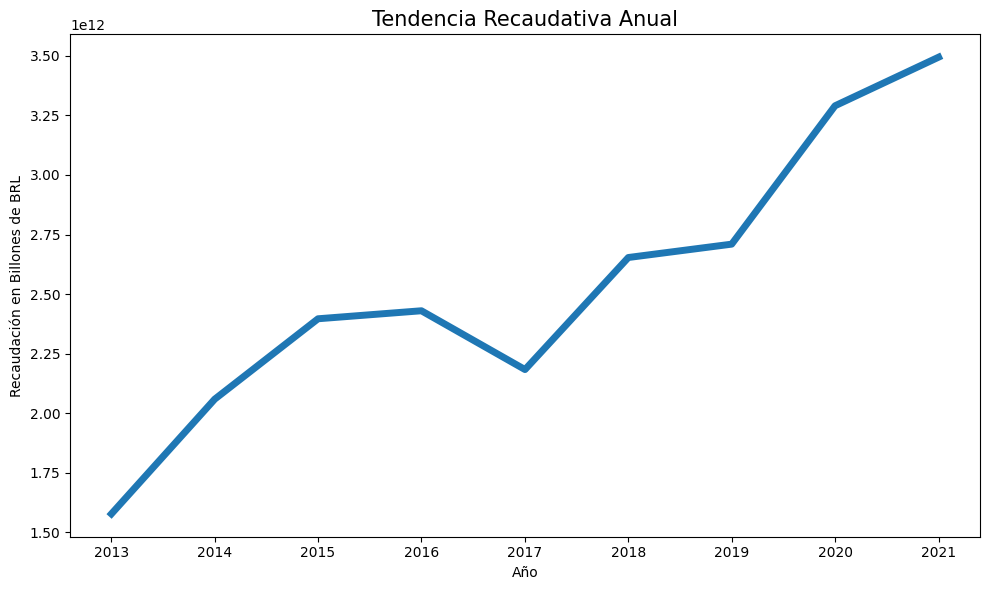

In [123]:
plt.figure(figsize=(10,6))
sns.lineplot(x= "ano_ejercicio",
             y= "valor_ejecutado",
             data = df_ingresos_anuales,
             palette= "mako",
             linewidth = 5)

plt.title("Tendencia Recaudativa Anual", fontsize = 15)

plt.xlabel("Año")
plt.ylabel("Recaudación en Billones de BRL")

plt.xticks(rotation=0)
plt.tight_layout()

- La gráfica muestra la tendencia recaudativa anual del gobierno brasileño, en reales. En general, es creciente, excepto en el año 2017, que muestra una caída pronunciada.

- Para entender la tendencia de la gráfica anterior, habría que determinar si la recaudación se corresponde con el GDP de ese período en Brasil. Para ello, usaremos la siguiente gráfica de Statista, que muestra el GDP en billones de USD:

![imagen](../imagenes/brazil-gdp.jpeg)

- Durante todo el período que muestra la gráfica (2007 a 2022), la tendencia es alcista, propio de los países del bloque "BRICS".

- En el año 2017, la economía Brasileña creció un 1,3%, siginificativamente por debajo al año anterior, que lo hizo un 3,3%. El entonces Ministro de Planificación dijo que esperaba una caída en los ingresos del gobierno en la misma línea que el GDP.

- Aunque estos datos explican parcialmente la caída, porcentualmente la diferencia es de casi un 10%, y podría requerir mayores averiguaciones. En la gráfica que sean analizados por categoría podremos entender mejor este fenómeno.

- Por su parte, la subida abrupta en 2020 y 2021 parece guardar más correlación con el crecimiento del GDP.

*** Source: Statista and https://www.reuters.com/article/instant-article/idINE4N18R007/ ***

In [84]:
df_ingresos_categoria

,categoria_economica,valor_ejecutado,valor_previsto_actualizado,ratio_ejec_total,ano_ejercicio
0,Ingresos de Capital,"11,260,681,585,317.42","13,168,832,871,799.4",49.0,2013-01-01
1,Ingresos Corrientes,"10,947,368,785,702.92","11,433,857,865,620.69",48.0,2013-01-01
2,Desconocido,"296,675,629,347.32","1,011,244,190,367.19",1.0,2013-01-01
3,Ingresos Corrientes - intra-presupuestarios,"270,773,436,849.65","268,676,634,102.0",1.0,2013-01-01
4,Ingresos de Capital - intra-presupuestarios,"20,096,501,112.780003","10,808,411,537.0",0.0,2013-01-01


In [104]:
df_ingresos_cat = df.groupby(["ano_ejercicio", "categoria_economica"])["valor_ejecutado"].sum().reset_index()
df_ingresos_cat

,ano_ejercicio,categoria_economica,valor_ejecutado
0,2013-01-01,Desconocido,"40,976,918,492.649994"
1,2013-01-01,Ingresos Corrientes,"879,208,917,752.87"
2,2013-01-01,Ingresos Corrientes - intra-presupuestarios,"23,891,444,118.78"
3,2013-01-01,Ingresos de Capital,"633,701,596,459.13"
4,2014-01-01,Desconocido,"5,094,201,269.13"
5,2014-01-01,Ingresos Corrientes,"1,077,782,753,531.72"
6,2014-01-01,Ingresos Corrientes - intra-presupuestarios,"34,509,263,932.55"
7,2014-01-01,Ingresos de Capital,"937,871,460,134.8"
8,2014-01-01,Ingresos de Capital - intra-presupuestarios,"4,012,627,739.69"
9,2015-01-01,Desconocido,"10,080,837,926.93"


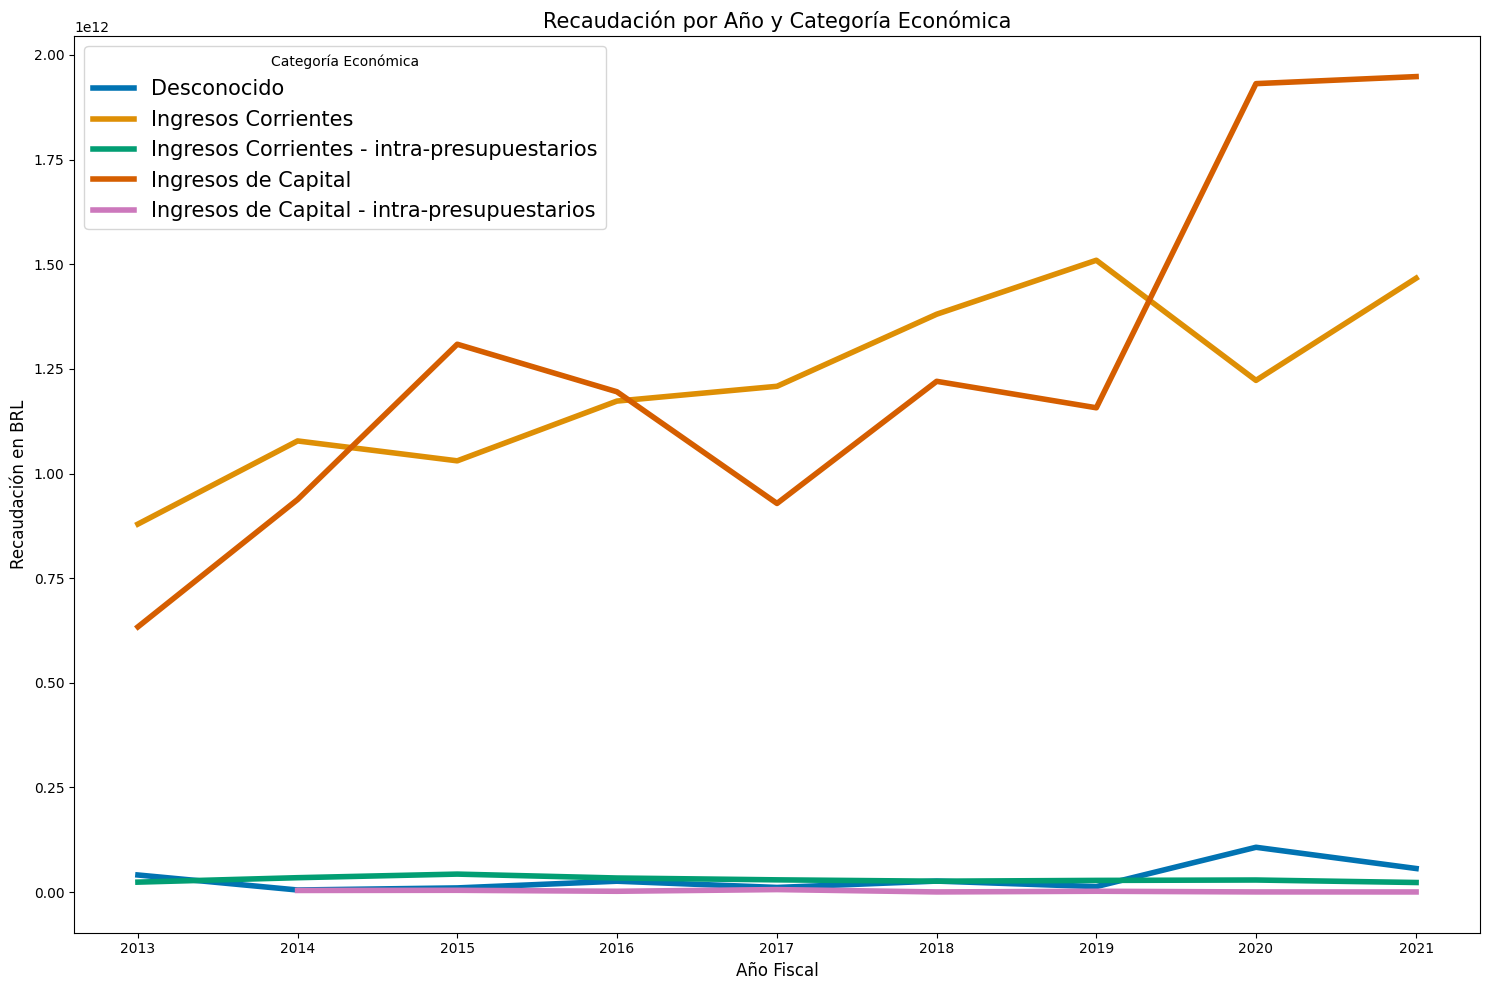

In [121]:
plt.figure(figsize=(15, 10))
sns.lineplot(x = "ano_ejercicio",
             y = "valor_ejecutado",
             hue = "categoria_economica",
             data = df_ingresos_cat,
             palette = "colorblind",
             linewidth = 4,
             markers = "x")


plt.title("Recaudación por Año y Categoría Económica", fontsize=15)
plt.xlabel("Año Fiscal", fontsize=12)
plt.ylabel("Recaudación en BRL", fontsize=12)
plt.legend(title="Categoría Económica", fontsize = 15)
plt.tight_layout()

La gráfica muestra la recaudación por año y categoría económica, y en ella podemos observar los siguientes comportamientos:

- Ingresos Corrientes (naranja): En general, se refieren a los impuestos. Esta categoría presenta la mayor recaudación a lo largo de los años, con un notable incremento desde 2013 hasta 2021, aunque con algunas fluctuaciones.

- Ingresos de Capital (rojo): Son aquellos relacionados con la venta de activos del Estado, los  de naturaleza no tributaria destinados a financiar operaciones de capital y los ingresos procedentes de activos y pasivos financieros. Esta categoría tiene un comportamiento intermedio, con recaudaciones que aumentan de manera más gradual en comparación con los "Ingresos Corrientes". Relacionado con la observación de la primera gráfica, tendría sentido que esta categoría caiga en 2017, por la potencial caída en el valor de los instrumentos financieros del gobierno brasileño.

- Otras Categorías: Las categorías "Ingresos Corrientes - intra-presupuestarios" (verde), "Ingresos de Capital - intra-presupuestarios" (morado), y "Desconocido" (azul) muestran recaudaciones mucho menores en comparación con "Ingresos Corrientes" y sus valores se mantienen casi constantes y cercanos a cero a lo largo de los años.

En resumen, la gráfica permite visualizar cómo las diferentes categorías económicas han contribuido a la recaudación total en Brasil a lo largo de estos años, destacando especialmente la importancia y el crecimiento constante de los "Ingresos Corrientes".

In [61]:
df_diferencia_cat

,categoria_economica,diferencia
0,Desconocido,"-42,442,894.0"
1,Ingresos Corrientes,"-574,579.0"
2,Ingresos Corrientes - intra-presupuestarios,"149,324.0"
3,Ingresos de Capital,"-73,182,146.0"
4,Ingresos de Capital - intra-presupuestarios,"111,904,694.0"


/var/folders/yj/y1bv8zk12j11bnjq1hc6x_d80000gn/T/ipykernel_29772/1766519368.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y= "categoria_economica",


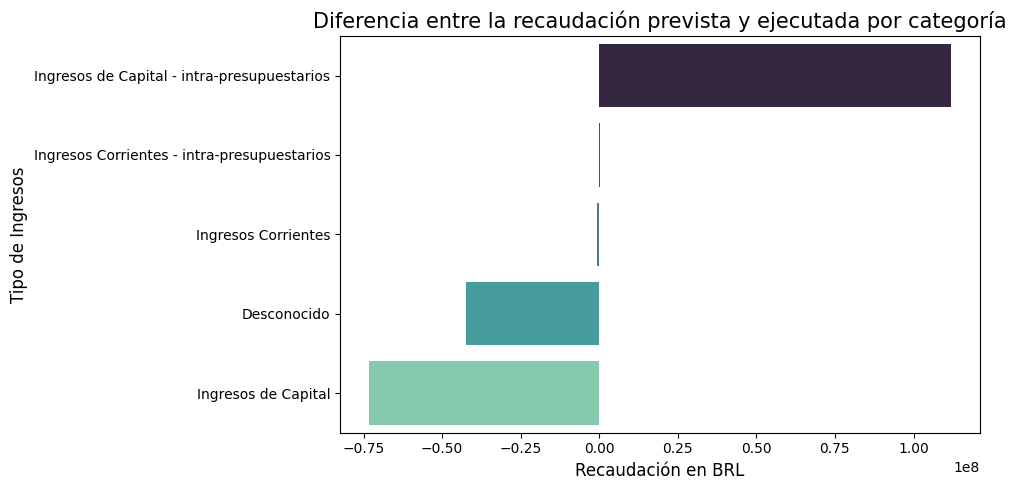

In [130]:
plt.figure(figsize=(10,5))
sns.barplot(y = "categoria_economica",
            x = "diferencia", 
            data = df_diferencia_cat.sort_values(ascending=False, by= "diferencia"), 
            palette = "mako")

plt.title("Diferencia entre la recaudación prevista y ejecutada por categoría", fontsize=15)
plt.xlabel("Recaudación en BRL", fontsize=12)
plt.ylabel("Tipo de Ingreso", fontsize=12)
plt.tight_layout()

- La gráfica  permite visualizar las discrepancias entre los ingresos previstos y los realmente recaudados en diferentes categorías económicas, lo cual es crucial para la planificación y gestión financiera. 

- Vemos barras que viajan en ambos sentidos, izquierda y derecha, indicando importantes discrepancias tanto en positivo como en negativo, de la recaudación prevista y la ejecutada.

In [125]:
df_previsto_ejecutado_cat

,categoria_economica,valor_ejecutado,valor_previsto_actualizado,diferencia,ratio_recaudado/previsto
0,Ingresos Corrientes,"1,297.13",0.0,"1,297.13",inf
1,Ingresos Corrientes,"26,666,621.42",0.0,"26,666,621.42",inf
2,Ingresos Corrientes,"301,251.13",0.0,"301,251.13",inf
3,Ingresos Corrientes,"1,855.58",0.0,"1,855.58",inf
4,Ingresos Corrientes,"52,140.68",0.0,"52,140.68",inf
...,...,...,...,...,...
903718,Ingresos de Capital,0.0,"10,247,198.0","-10,247,198.0",-100.0
903719,Ingresos de Capital,0.0,"16,940,891.0","-16,940,891.0",-100.0
903720,Ingresos Corrientes,0.0,"200,000.0","-200,000.0",-100.0
903721,Ingresos Corrientes,"1,000,000.0",0.0,"1,000,000.0",inf


/var/folders/yj/y1bv8zk12j11bnjq1hc6x_d80000gn/T/ipykernel_29772/14914953.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x = "categoria_economica",


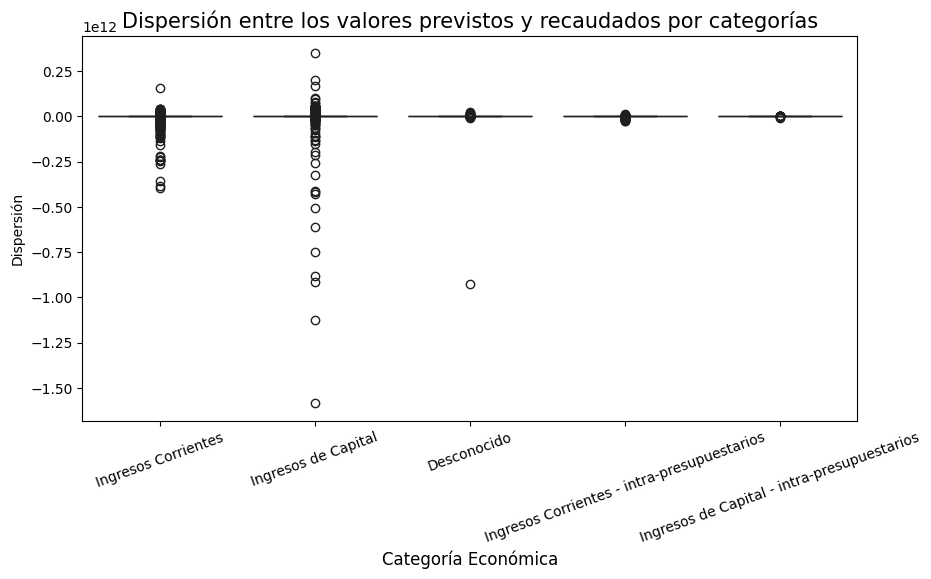

In [129]:
plt.figure(figsize = (10,5))
sns.boxplot(x = "categoria_economica",
            y = "diferencia",
            data = df_previsto_ejecutado_cat, 
            palette = "mako",
            )


plt.xticks(rotation = 20)
plt.title("Dispersión entre los valores previstos y recaudados por categorías", fontsize = 15)
plt.xlabel("Categoría Económica", fontsize = 12)
plt.ylabel("Dispersión")

plt.show()

- La gráfica muestra la dispersión entre los valores previstos y recaudados por diferentes categorías económicas. La dispersión tan elevada causa que este boxplot no pueda verse correctamente.

- Entendemos que, por la gran cantidad de outliers en la que es la principal cuenta del gobierno brasileño -ingresos de capital-, tanto en positivo como en negativo, es indicativo de una falta de una adecuada planificación al momento de prever los ingresos por parte del gobierno brasileño.

## Resumen

- En lo que respecta a las categorías de ingresos, se destacan dos principales, que representan el 48% y 49% de los ingresos totales: los ingresos corrientes y los ingresos de capital. Esta distribución es lógica, ya que refleja las principales fuentes de recursos para cualquier gobierno: por un lado, los impuestos, que corresponden a los ingresos corrientes, y por otro, las inversiones y activos financieros, que componen los ingresos de capital.

- Al comparar las proyecciones de ingresos con los ingresos efectivamente recaudados, se observa consistentemente que las estimaciones superan la recaudación real. Específicamente, las partidas de ingresos corrientes y de capital han recaudado, durante el período de análisis, aproximadamente 1 billón de BRL por debajo de lo presupuestado. Esta situación sugiere la necesidad de revisar los métodos de proyección y analizar posibles sesgos o incentivos que puedan llevar a sobreestimar los ingresos, contribuyendo así al crecimiento del déficit fiscal.

- Continuando con el análisis temporal, se observa un crecimiento continuo en la recaudación anual, con una disminución en 2017 y un aumento notable en 2020 y 2021. Mientras que la caída en 2017 muestra poca correlación con el comportamiento del PIB, el repunte en los últimos dos años parece estar directamente vinculado al crecimiento económico.

- Sin embargo, persiste la preocupación de que las proyecciones de ingresos continúen siendo inexactas, y en algunos casos, la recaudación registrada supera los montos oficialmente reportados, lo que plantea interrogantes sobre la gestión de los ingresos no contabilizados adecuadamente.

- Como recomendación, podría analizarse la tendencia mensual de los distintos años, aunque no tenemos datos para 2013 y 2014. Este análisis podría revelar datos adicionales que, por una limitante de tiempo se han excluído de esta primera versión.
